## Data analysis code for gain=5000 data taken on 08/28/2025. Binning 1x1
Used for scanning frequency on solid target. 

In [1]:
import numpy as np  
import matplotlib.pyplot as plt
import re
import os
from scipy import optimize
from scipy.ndimage import gaussian_filter
import h5py
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import butter, sosfiltfilt, sosfreqz

## Define functions for Gaussian fitting

In [2]:
def gaussian(p,x):
    return p[0]/(p[1]*(2*np.pi)**.5)*np.exp(-.5*(x-p[2])**2/(p[1]**2))

#p[0]=multiplicative const
#p[1]=std
#p[2]=mean

def residual(p,x,y,dy):
    return (gaussian(p,x)-y)/dy

In [3]:
def gaussian_fit(counts,probability,probability_uncertainty,p0,plotting_values,show_details):
    ## Implement Gaussian fit
    index_Start, index_End, Plotfit_min, Plotfit_max, Dataplot_min, Dataplot_max = plotting_values
    counts_for_gaussian=counts[index_Start:index_End]
    probability_for_gaussian=probability[index_Start:index_End]
    probability_uncertainty_for_gaussian=probability_uncertainty[index_Start:index_End]
    pf, cov, info, mesg, success = optimize.leastsq(residual, p0, args = (counts_for_gaussian, probability_for_gaussian, 
                                                                          probability_uncertainty_for_gaussian), full_output=1, maxfev=5000)
    ## Plot data and fit
    if cov is None:
        print('fit region: AD count = ', min(counts_for_gaussian), 'to ', max(counts_for_gaussian))
        print('Fit did not converge')
        print('Success code:', success)
        print(mesg)
        fig = plt.figure(figsize=(8,5))
        ax = fig.add_subplot(111)
        ax.errorbar(counts, probability, probability_uncertainty, fmt='k.', label = 'Data',alpha=0.5) 
            #In DarkFrameHistogramFit_polished.ipynb this plots only in the fitted range counts_for_gaussian, but this shouldn't matter if we plot it over all data points.
        x = np.linspace(Plotfit_min,Plotfit_max,1000)
        ax.plot(x, gaussian(p0, x), 'b-', label = 'Guess')
        ax.legend()
        ax.set_title('Gaussian Fit')
        ax.set_xlabel('AD count')
        ax.set_ylabel('Probability')
        ax.set_yscale('log')
        ax.set_xlim([Dataplot_min,Dataplot_max])
        ax.grid()
        plt.show()
    else:
        pferr = [np.sqrt(cov[i,i]) for i in range(len(pf))]
        if show_details:
            print('fit region: AD count = ', min(counts_for_gaussian), 'to ', max(counts_for_gaussian))
            print('Fit Converged')
            chisq = sum(info['fvec']*info['fvec'])
            dof = abs(len(counts_for_gaussian)-len(pf))
            print('Converged with chi-squared', chisq)
            print('Number of degrees of freedom, dof =',dof)
            print('Reduced chi-squared', chisq/dof)
            print('Inital guess values:')
            print('  p0 =', p0)
            print('Best fit values:')
            print('  pf =', list(pf))
            print('Uncertainties in the best fit values:')
            print('  pferr =', pferr)
            print("5 sigma threshold is", pf[2]+pf[1]*5, "with uncertainty", pferr[2]+pferr[1]*5)
            fig = plt.figure(figsize=(8,5))
            ax = fig.add_subplot(111)
            ax.errorbar(counts, probability, probability_uncertainty, fmt='k.', label = 'Data',alpha=0.5)
            x = np.linspace(Plotfit_min,Plotfit_max,1000) #plot fitted curve
            ax.set_yscale('log')
            ax.plot(x, gaussian(pf, x), 'r-', label = 'Fit curve')
            ax.axvspan(min(counts_for_gaussian), max(counts_for_gaussian), alpha=0.4, color='red', label = 'Fitted region')
            ax.set_title('Gaussian Fit', fontsize=16)
            ax.set_xlabel('AD count', fontsize=16)
            ax.set_ylabel('Probability', fontsize=16)
            ax.grid()
            ax.legend(loc=3)
            ax.set_xlim([Dataplot_min,Dataplot_max])
            # ax.set_ylim([1e-6,1e-1])
            plt.tight_layout()
            plt.show()
    return pf

In [4]:
folder_path_day = r'C:\Experiments\lyman29\BaF_Fluorescence\2025\08\29'

# Define PC thresholds for binning=1x1, EMCCD gain=1000

Text(0, 0.5, 'Number of Pixels')

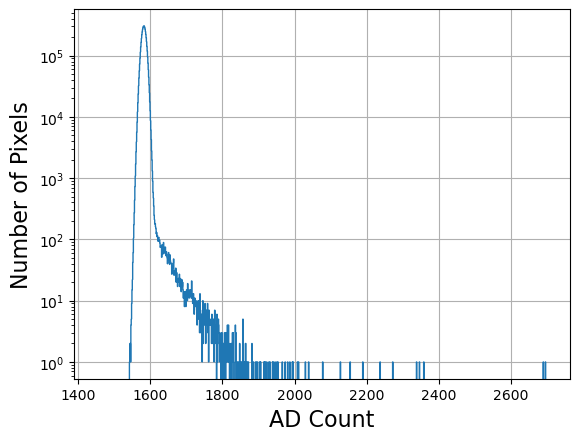

In [5]:
# get threshold values from averaged 0mW data
all_images = np.full((300, 512, 512), np.NaN)
folder_path = folder_path_day + '\\0001'
for count_b, filename in enumerate(os.listdir(folder_path)):
    file_path = os.path.join(folder_path, filename)
    with h5py.File(file_path, 'r') as file:
        image_data = file['images/camera/fluorescence/frame'][:]
        all_images[count_b, :, :] = image_data

background_counts = all_images.ravel()

#Plot histogram for total 300 pics
plt.figure(3)
background_bins=plt.hist(background_counts,bins=np.arange(1450.5,2700.5, 1),log=True, histtype='step')
counts=background_bins[1][:-1]+.5
counts=counts.astype(int)

plt.grid()
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of Pixels', fontsize=16)

# # Plot error rate 
# plt.figure(4)
# plt.hist(background_counts,bins=np.arange(1450.5,2700.5),log=True, histtype='step', density = True, cumulative=-1)
# plt.xlabel('Threshold', fontsize=16)
# plt.ylabel('Error rate', fontsize=16)
# plt.show()

[6.79935414e-02 7.00000000e+00 1.58200000e+03]
[119, 149, 1563, 1607, 1480, 1900]
fit region: AD count =  1570 to  1599
Fit Converged
Converged with chi-squared 114.7023547441587
Number of degrees of freedom, dof = 27
Reduced chi-squared 4.248235360894767
Inital guess values:
  p0 = [0.0679935413876945, 7, 1582]
Best fit values:
  pf = [0.0664254323730552, 6.83953305080863, 1582.578520306936]
Uncertainties in the best fit values:
  pferr = [3.011972142013741e-05, 0.0030562459971825565, 0.003420203036774346]
5 sigma threshold is 1616.7761855609792 with uncertainty 0.018701433022687126


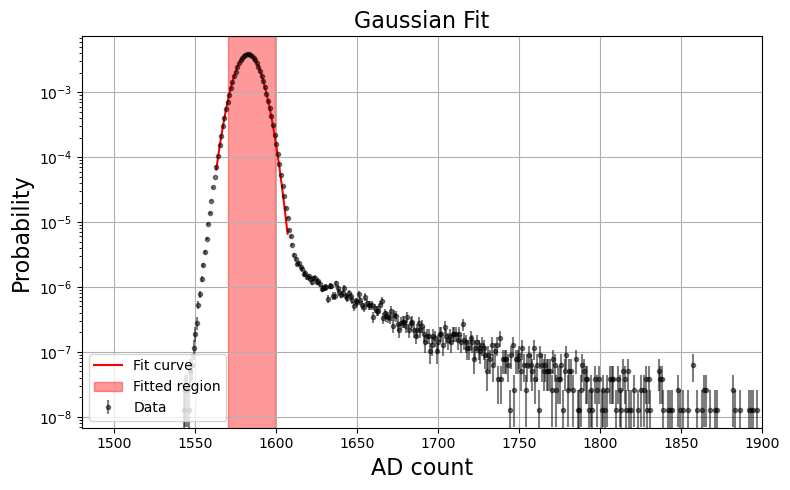

In [8]:
# Get threshold
probability=background_bins[0]/len(background_counts) #Assuming each pixel get 0 or 1 photon -SF
probability_uncertainty=(.1+background_bins[0])**.5/len(background_counts) #Shot noise? -SF
peak_probability = np.max(probability)
peak_index = np.argmax(probability)
peak=counts[peak_index]

#Select x region where you want to fit the gaussian: this can be arbirary
Start_gaussian=1570
End_gaussian=1600

index_Start = np.abs(counts - Start_gaussian).argmin() #closest_index_to_Start_gaussian
index_End = np.abs(counts - End_gaussian).argmin() #closest_index_to_End_gaussian

# Select x region where you want to plot the fitted gaussian: this must include the above region
Plotfit_min = counts[index_Start] -7
Plotfit_max = counts[index_End] +7

# Select x region where you want to plot the data: this must include the above region
Dataplot_min = 1480
Dataplot_max = 1900

# Guess the std of your Gaussian fit!
guess_std=7

print(np.array([peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak]))
# Now apply the Gaussian fit to your histogram and plot...
plotting_values = [index_Start, index_End, Plotfit_min, Plotfit_max, Dataplot_min, Dataplot_max]
print(plotting_values)
pf=gaussian_fit(counts,probability,probability_uncertainty, [peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak], plotting_values,show_details=True) #Note that peak value of normal distribution with std=X is 1/(X*sqrt(2pi))
 

# Photon counting LIF with threshold count=1617

# B-field scan

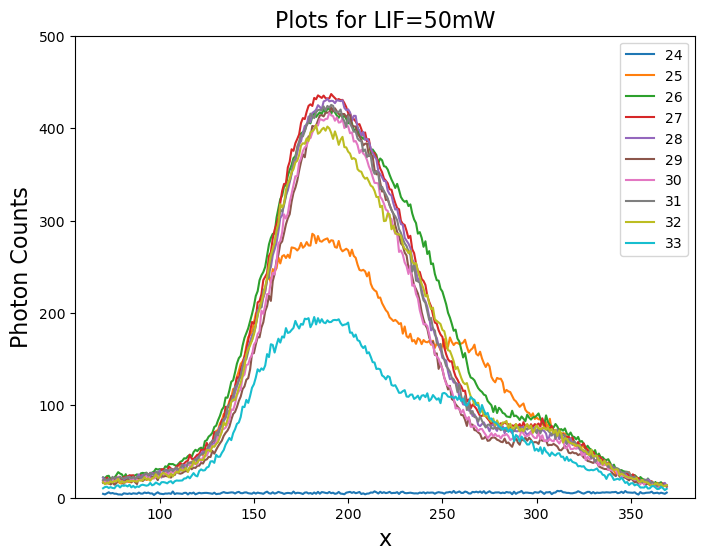

In [28]:
## get averaged plot shape in each sequence

fig = plt.figure(20, figsize=(8,6))

for seq in np.arange(24, 34):
    folder_path = folder_path_day + '\\%.4i'%seq
    photon_array=[] #average number of photons
    freq_array=[]
    cross_section_x_tot=None
    count=0
    
    for count_b, filename in enumerate(os.listdir(folder_path)): 
        file_path = os.path.join(folder_path, filename)
        if not count_b==0:
            with h5py.File(file_path, 'r') as file:
                image_data = file['images/camera/fluorescence/frame'][:]
                image_data[image_data<1617]=0
                cross_section_x = np.count_nonzero(image_data, axis=0)
                if cross_section_x_tot is None:
                    cross_section_x_tot = np.zeros_like(cross_section_x, dtype=np.float64)
                cross_section_x_tot += cross_section_x 
            count+=1
    
    
    cross_section_x_tot = cross_section_x_tot/count
    plt.plot(np.arange(70,370,1),cross_section_x_tot[70:370], label=seq)

plt.xlabel('x', fontsize=16)
plt.ylim([0,500])
# plt.title('Shots in Seq.7', fontsize=16)
plt.title('Plots for LIF=50mW', fontsize=16)
plt.ylabel('Photon Counts', fontsize=16)
plt.legend()
plt.show()

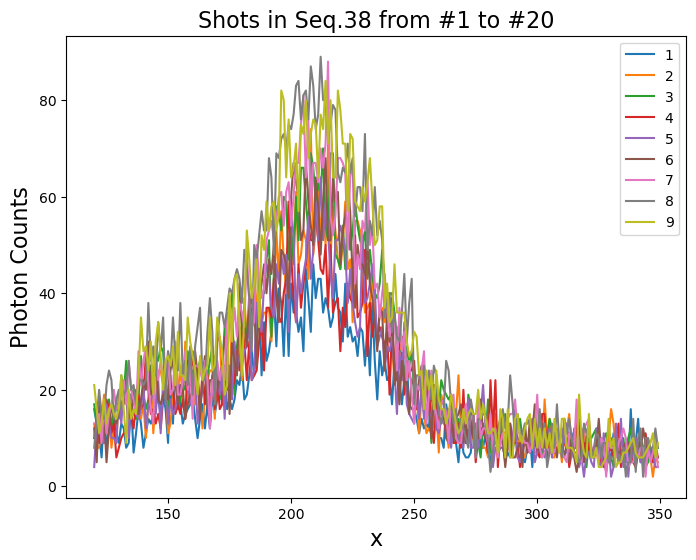

total # of photons =  49064
total_counts= 9
average # of photons =  5451.555555555556


In [42]:
# Photon counts for each of the shots
seq = 38 #sequence number
count_b_start=1
count_b_end=20

folder_path = folder_path_day + '\\%.4i'%seq
sum_array=[] #average number of photons
fig = plt.figure(20, figsize=(8,6))
total_counts=0
# get x-cross section for every shot in the sequence
for count_b, filename in enumerate(os.listdir(folder_path)): 
    file_path = os.path.join(folder_path, filename)
    if count_b<=count_b_end and count_b>=count_b_start:
    # if np.any(np.array([4,6,8,9,12,14,15, 17, 18])==count_b):
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            image_data[image_data<1617]=0
            cross_section_x = np.count_nonzero(image_data, axis=0)
            
            plt.plot(np.arange(120,350,1),cross_section_x[120:350], label=count_b)
            sum_array.append(np.sum(cross_section_x[120:350]))
            total_counts+=1


# plt.ylim([1528,1660])
plt.xlabel('x', fontsize=16)
# plt.title('Shots in Seq.7', fontsize=16)
plt.title('Shots in Seq.%i from #%i to #%i' %(seq, count_b_start, count_b_end), fontsize=16)
plt.ylabel('Photon Counts', fontsize=16)
plt.legend()
plt.show()

print("total # of photons = ", np.sum(sum_array))
print("total_counts=", total_counts)
print("average # of photons = ", np.sum(sum_array)/total_counts)


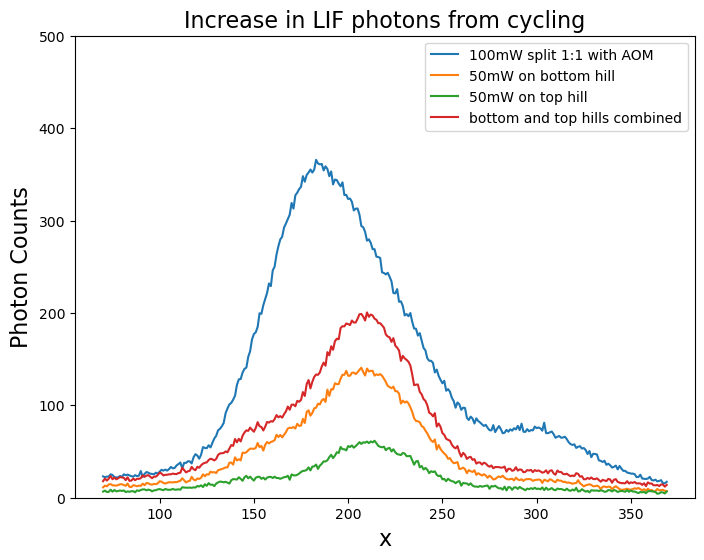

In [39]:
## get averaged plot shape in each sequence

fig = plt.figure(20, figsize=(8,6))
legend_labels = ['100mW split 1:1 with AOM', '50mW on bottom hill', '50mW on top hill']
sequences = [36, 37, 38]

for i, seq in enumerate(sequences):
    folder_path = folder_path_day + '\\%.4i'%seq
    photon_array=[] #average number of photons
    freq_array=[]
    cross_section_x_tot=None
    count=0
    
    for count_b, filename in enumerate(os.listdir(folder_path)): 
        file_path = os.path.join(folder_path, filename)
        if not count_b==0:
            with h5py.File(file_path, 'r') as file:
                image_data = file['images/camera/fluorescence/frame'][:]
                image_data[image_data<1617]=0
                cross_section_x = np.count_nonzero(image_data, axis=0)
                if cross_section_x_tot is None:
                    cross_section_x_tot = np.zeros_like(cross_section_x, dtype=np.float64)
                cross_section_x_tot += cross_section_x 
            count+=1
    
    
    cross_section_x_tot = cross_section_x_tot/count
    plt.plot(np.arange(70,370,1),cross_section_x_tot[70:370], label=legend_labels[i])
    if seq == 37:
        cross_section_37 =cross_section_x_tot
    if seq == 38:
        cross_section_38 =cross_section_x_tot


#Plot the sum of top and bottom hills
plt.plot(np.arange(70,370,1),cross_section_37[70:370] + cross_section_38[70:370], label='bottom and top hills combined')

plt.xlabel('x', fontsize=16)
plt.ylim([0,500])
# plt.title('Shots in Seq.7', fontsize=16)
plt.title('Increase in LIF photons from cycling', fontsize=16)
plt.ylabel('Photon Counts', fontsize=16)
plt.legend()
plt.show()